## Week 2: Dataset Acquisition and Preprocessing 

In [3]:
#install the libraries: 
### pytorch for python3.12

# brew install python@3.12
# python3.11 --version
# python3.11 -m venv myenv
# source myenv/bin/activate
# pip install torch torchvision torchaudio

#verify the intallation 


In [21]:
import torch

In [22]:
print(torch.__version__)

2.6.0


In [6]:
# download the dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia 

In [17]:
#import the libraries 
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt # always come together
import numpy as np

In [19]:
#upload the data
data_train = "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/train"
data_test = "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/test"
data_val = "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/val"


In [11]:
# Define the transformations with data augmentation
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),  # Resize to 128x128 (Height, Width)
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),  # Resize to 128x128 (Height, Width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 (Height, Width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [13]:
# How many images are in each folder for each class? 

import os

# Define the directories
data_dirs = {
    "Train": "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/train",
    "Test": "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/test",
    "Validation": "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/val",
}

# Count the number of images in each subfolder (PNEUMONIA, NORMAL)
for category, path in data_dirs.items():
    print(f"\n{category} Set:")
    
    for class_name in ["PNEUMONIA", "NORMAL"]:  # Check specific folders
        class_path = os.path.join(path, class_name)
        
        if os.path.isdir(class_path):  # Ensure it's a folder
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            print(f"  - {class_name}: {num_images} images")
        else:
            print(f"  - {class_name}: Folder not found")



Train Set:
  - PNEUMONIA: 3875 images
  - NORMAL: 1341 images

Test Set:
  - PNEUMONIA: 390 images
  - NORMAL: 234 images

Validation Set:
  - PNEUMONIA: 8 images
  - NORMAL: 8 images


Train Set:
  - PNEUMONIA: 3875 images
  - NORMAL: 1341 images

Test Set:
  - PNEUMONIA: 390 images
  - NORMAL: 234 images

Validation Set:
  - PNEUMONIA: 8 images
  - NORMAL: 8 images

# Adressing imbalance of the data in training set: 
imbalance would create an overfit toward the majority class
solutions:
1) downsample the majority class: downside - loss of information
2) oversample the minority class: 
3) class weight in loss function: modifies the loss function to assign a higher penalty to misclassifications of the minority class. 
        - should be done at the later stage.
        

In [21]:
# My choice is oversampling the minority class:
 
#load the libs
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch
import os
import random
from PIL import Image

# Load dataset (not yet transformed)
dataset = datasets.ImageFolder(root=data_train, transform=transform_train)


# Get class indices
class_indices = dataset.class_to_idx  # {'NORMAL': 0, 'PNEUMONIA': 1}
normal_idx = class_indices['NORMAL']
pneumonia_idx = class_indices['PNEUMONIA']

# Separate NORMAL and PNEUMONIA images
normal_images = [img_path for img_path, label in dataset.samples if label == normal_idx]
pneumonia_images = [img_path for img_path, label in dataset.samples if label == pneumonia_idx]

# Count images per class
num_normal = len(normal_images)
num_pneumonia = len(pneumonia_images)

print(f"Original count: NORMAL = {num_normal}, PNEUMONIA = {num_pneumonia}")


Original count: NORMAL = 1341, PNEUMONIA = 3875


In [23]:
# Oversample NORMAL images by randomly duplicating them
oversampled_normal_images = normal_images * (num_pneumonia // num_normal)  # Duplicate fully
oversampled_normal_images += random.sample(normal_images, num_pneumonia - len(oversampled_normal_images))  # Add remaining

In [25]:
# create the dataset for the train set(normal oversampled + pneumonia)

class OversampledDataset(Dataset):
    def __init__(self, normal_images, pneumonia_images, transform=None):
        self.image_paths = normal_images + pneumonia_images  # Merge both classes
        self.labels = [0] * len(normal_images) + [1] * len(pneumonia_images)  # Assign labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert("L")  # 'L' mode is for grayscale (1 channel)
        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label

# Create dataset
balanced_dataset = OversampledDataset(oversampled_normal_images, pneumonia_images, transform_train)

# Create DataLoader
train_loader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)

# Verify batch distribution
num_normal_batch = sum(1 for _, labels in train_loader for label in labels if label == 0)
num_pneumonia_batch = sum(1 for _, labels in train_loader for label in labels if label == 1)

print(f"After Oversampling: NORMAL = {num_normal_batch}, PNEUMONIA = {num_pneumonia_batch}")


After Oversampling: NORMAL = 3875, PNEUMONIA = 3875


## Visualize as sample of preprocessinf

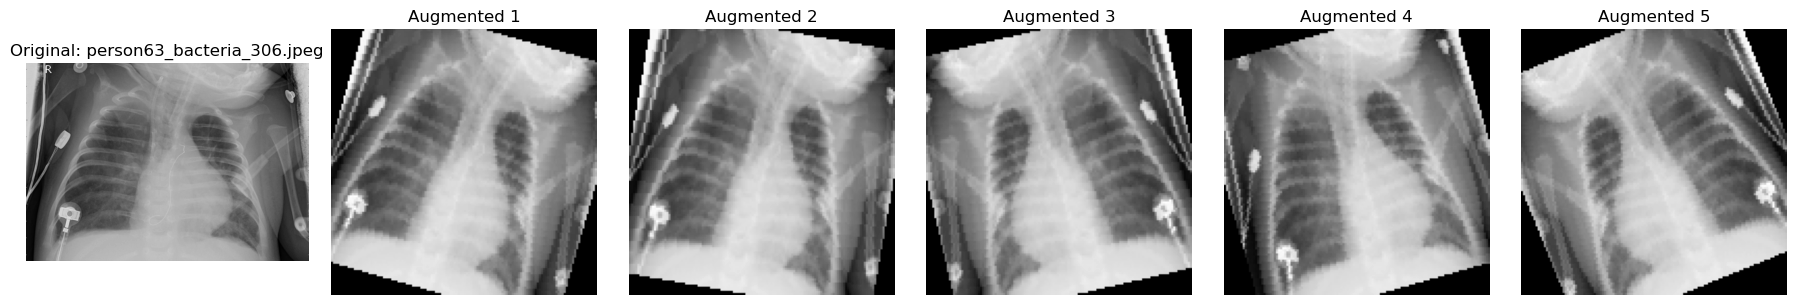

In [31]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Path to a sample image in your dataset
img_path = "/Users/cholponzhakshylykova/Desktop/SDS/pytorch/chest_xray/train/PNEUMONIA"
sample_img = os.listdir(img_path)[0]  # Get the first image in the directory

# Load the image
image = Image.open(os.path.join(img_path, sample_img))

# Convert to grayscale explicitly before applying transformations
image = image.convert('L')  # 'L' mode is for grayscale

# Define grayscale-compatible transformations (e.g., without color jitter)


# Apply the transformations to the image
augmented_images = [transform_train(image) for _ in range(5)]  # Apply the transformation 5 times to generate 5 augmented images

# Plot the original and augmented images
fig, axes = plt.subplots(1, 6, figsize=(18, 3))  # 6 subplots: 1 for the original and 5 for augmented images
axes[0].imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale images
axes[0].set_title(f"Original: {sample_img}")  # Display the original image name
axes[0].axis('off')  # Hide axis

for i, aug_img in enumerate(augmented_images):
    axes[i + 1].imshow(aug_img.permute(1, 2, 0), cmap='gray')  # Convert from CHW to HWC and apply 'gray' colormap
    axes[i + 1].set_title(f"Augmented {i + 1}")
    axes[i + 1].axis('off')  # Hide axis

plt.tight_layout()
plt.show()


In [33]:
# create data loader: 
val_dataset = datasets.ImageFolder(data_val, transform=transform_val)
test_dataset = datasets.ImageFolder(data_test, transform=transform_val)


# Create data loaders
train_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)